# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

# Часть 1. SQL

Дана упрощенная схема базы данных:

![](https://drive.google.com/uc?export=view&id=1eZVg0OMLNh3Zn4Ss00oNw6KtcMYMTtdZ)

**telemetry** - таблица с телеметрией карьерных самосвалов следующего формата:

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 | 21:00:54 | 35 | 85,694 | 51.384 | 41.857 | 15.81 |

где
* id - номер записи в таблице
* objectid - идентификатор самосвала
* time - момент времени
* sensorid - идентификатор датчика
* value - значение, которое передал датчик
* lat, lon - координаты
* speed - текущая скорость самосвала

**objects** - таблица, в которой хранится информация о самосвалах:

| id | modelname | enterprise_id | created_at |
| :-: |:-: |:-: |:-: |
| 123 | БелАЗ-75131 | 4 | 01.01.2024 | 00:00:00 |

где
* id - идентификатор самосвала
* modelname - модель самосвала
* enterprise_id - идентификатор предприятия
* created_at - временная метка создания записи

**sensors** - таблица с описанием датчиков:

| id | name | tag | min_value | max_value |
| :-: |:-: |:-: |:-: | :-: |
| 35 | Вес | weight | 0 | 180 |

где
* id - идентификатор датчика
* name - наименование датчика
* tag - тег датчика
* min_value - минимальное допустимое значение датчика
* max_value - максимальное допустимое значение датчика


## Задание 1
Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75320” на предприятии с id = 6 выведет процент количества записей телеметрии, когда значение тега высоты (height) находилось в допустимых пределах, относительно всех записей по данному датчику за последние сутки.

In [ ]:
with sens2 as (
  SELECT obj.id as obj_id, obj.modelname as model, obj.enterprise_id as enterprise_id, sen.id as sen_id, sen.name as sen_name, sen.tag as sen_tag,
  (CASE WHEN tel.value NOT BETWEEN sen.min_value and sen.max_values THEN 1 ELSE 0 END) as overlimit
  from objects obj
  left join telemerty tel on obj.id = tel.objectid
  left join sensors sen on tel.sensorid = sen.id
  WHERE obj.modelname = 'БелАЗ-7532' and obj.enterprise_id = 6
  and sen.tag = 'height' and tel.time = (SELECT max(time) from telemetry)
)
SELECT sens2.obj_id ,sens2.model, sens2.enterprise_id, sens2.sen_id , sens2.sen_name , sens2.sen_tag, (sum(sens2.overlimit) / count(sens2.overlimit) * 100) as overlimit_percent
from sens2
GROUP BY 1,2,3,4,5,6;

## Задание 2
Необходимо написать запрос, для вывода уникальных значений по датчику satenum (количество доступных спутников связи) для каждого самосвала с идентификатором из списка [34, 42, 99] за последние двое суток.

In [ ]:
SELECT DISTINCT tel.objectid , tel.sensorid, sen.name , tel.value
from telemetry tel
join sensors sen on tel.sensorid = sen.id
WHERE sen.name = 'satenum' and tel.objectid IN (34,42,99)
and tel.time IN (SELECT UNIQUE time from telemetry ORDER BY 1 DESC LIMIT 2 OFFSET 0);

## Задание 3
В таблицу с телеметрией собираются данные с датчика уровня топлива в процентах (тег fuel_tank_level). В данной задаче будем считать, что самосвалы в течение последнего часа ездят непрерывно, а значит и уровень топлива постепенно снижается. Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75131” вернет 1, если был зафиксирован хоть один случай, когда между двумя последовательными временными точками изменение уровня топлива было более 5%, или вывести 0, если подобной аномалии не было.

In [ ]:
# здесь сравнение будет между днями(telemetry.time), так как часов, минут и секунд в таблице нет,хотя  поле telemetry.sensorid подзрительно похож на HH:MM:SS , однако указано что это идентификатор
# так же по условию сказано учитывать и понижение уровня топлива, и повышение .
# и так же не понятны временные рамки,я так понял что имеется ввиду  вообще за все время для каждого самосвала.
with tel1 as (
  SELECT tel.modelname, tel.objectid, tel.sensorid, sen.tag, tel.time,(CASE
    WHEN abs(tel.value - lead(tel.value, 1, tel.value)
    OVER (PARTITION BY tel.objectid, tel.sensorid ORDER BY tel.modelname,tel.objectid,tel.sensorid,tel.time))>5 THEN 1
    ELSE 0 END ) as difference_between_day
  FROM telemetry tel
  join sensors sen on tel.sensorid = sen.id
  WHERE modelname = 'БелАЗ-75131' and sen.tag = 'fuel_tank_level'
  ORDER BY 1,2,3,4,5
)
SELECT DISTINCT modelname, objectid, max(difference_between_day) as abnormal_fuel_lvl
FROM tel1
GROUP BY 1,2
ORDER BY 1,2;

# Часть 2. Python

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426322 entries, 56789 to 322443
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   objectid              426322 non-null  int64                                
 1   time                  426322 non-null  datetime64[ns, pytz.FixedOffset(420)]
 2   lat                   426322 non-null  float64                              
 3   lon                   426322 non-null  float64                              
 4   speed                 426322 non-null  float64                              
 5   height                426322 non-null  float64                              
 6   fuel_cons             426322 non-null  float64                              
 7   engine_speed          259203 non-null  float64                              
 8   hdop                  426322 non-null  float64              

<ipython-input-2-d0e8bc585039>:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)


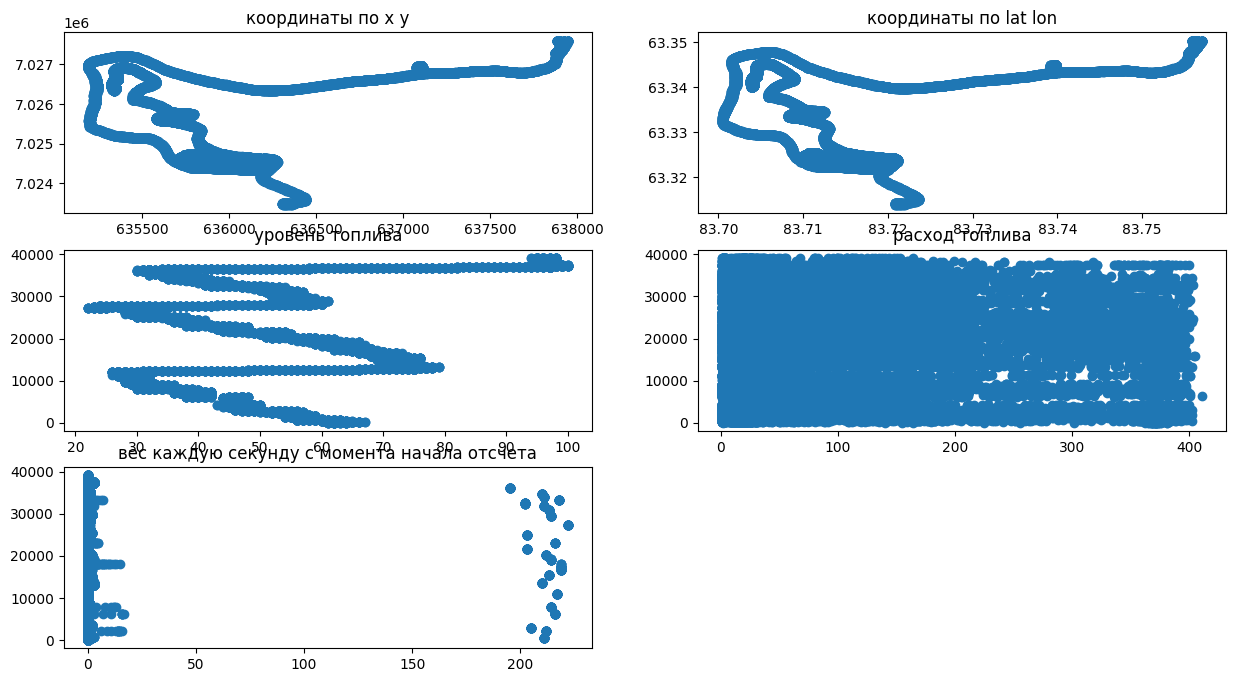

данные по самоcвалу 1123 при w_fl=1


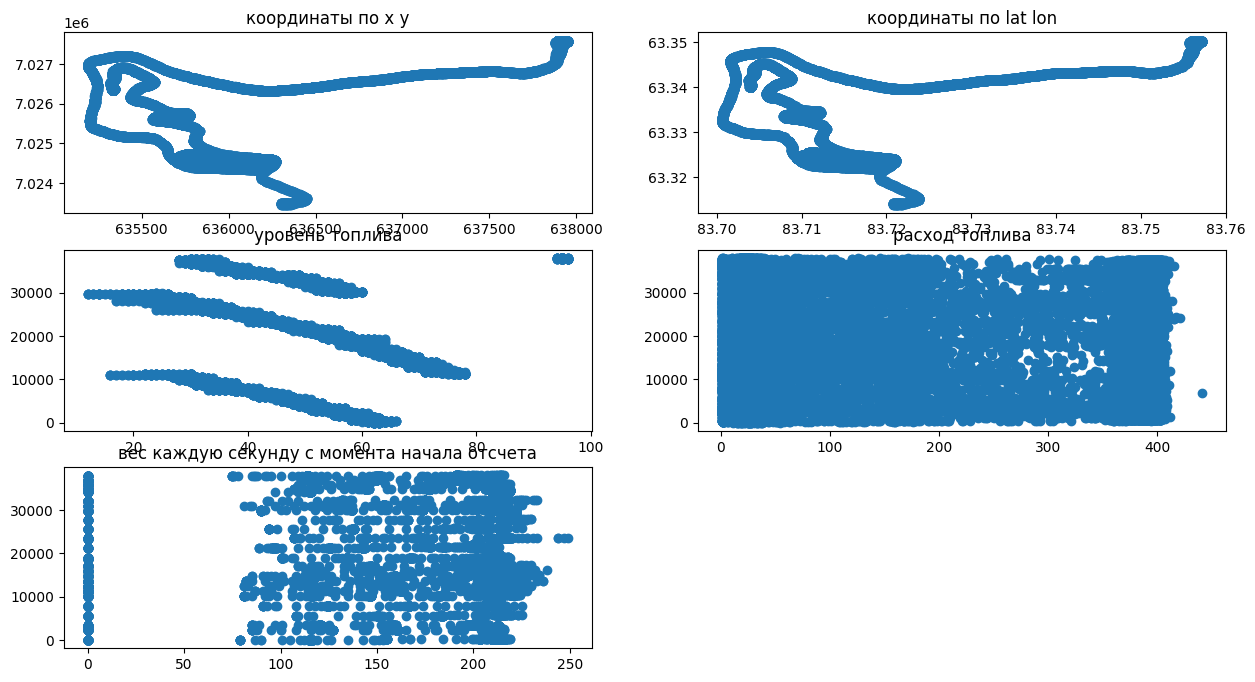

данные по самоcвалу 1124 при w_fl=0


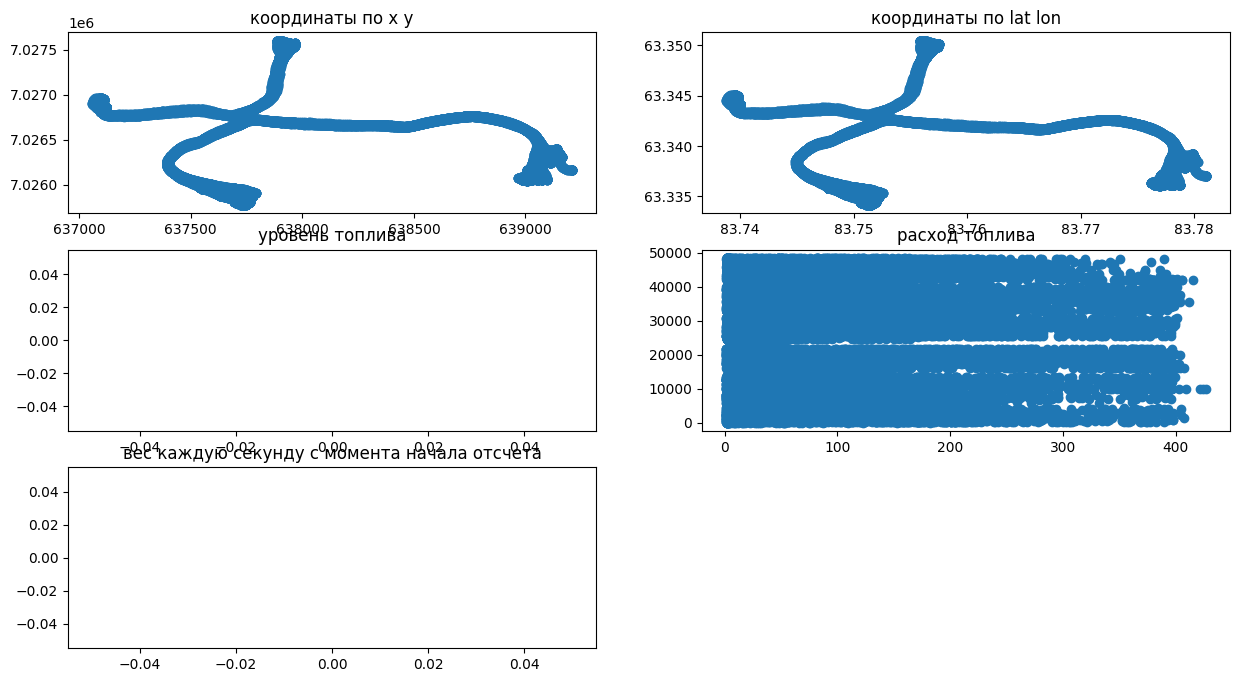

данные по самоcвалу 1124 при w_fl=1


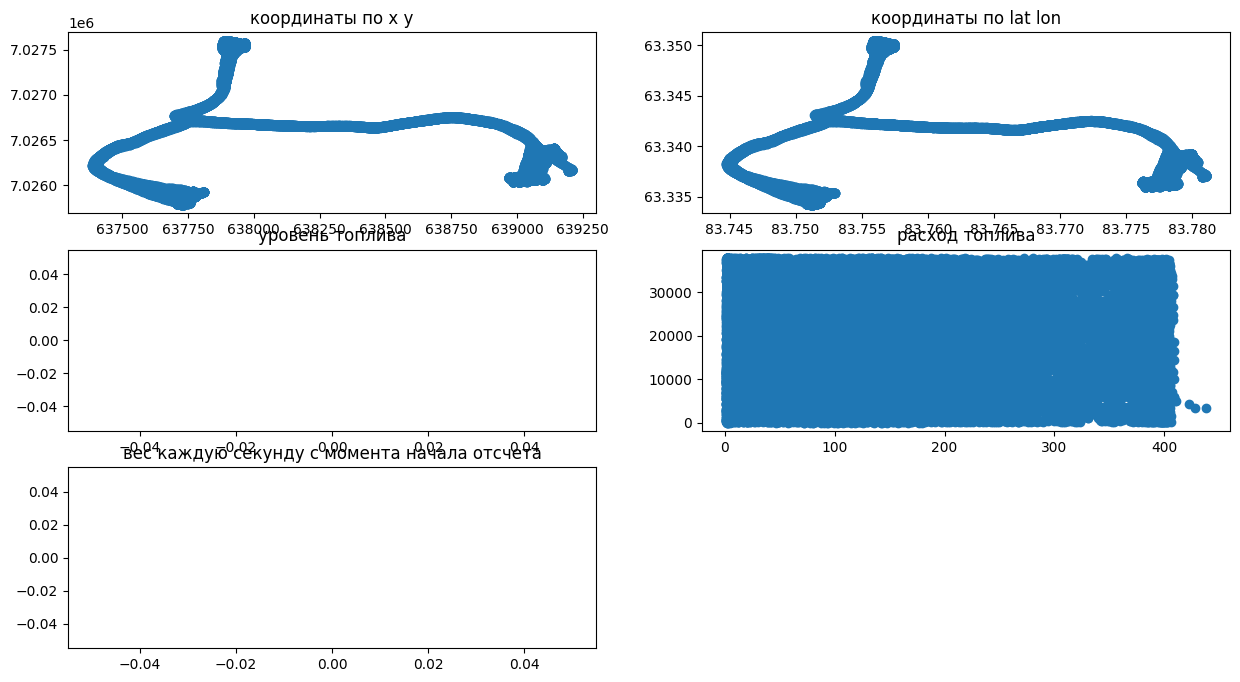

данные по самоcвалу 1125 при w_fl=0


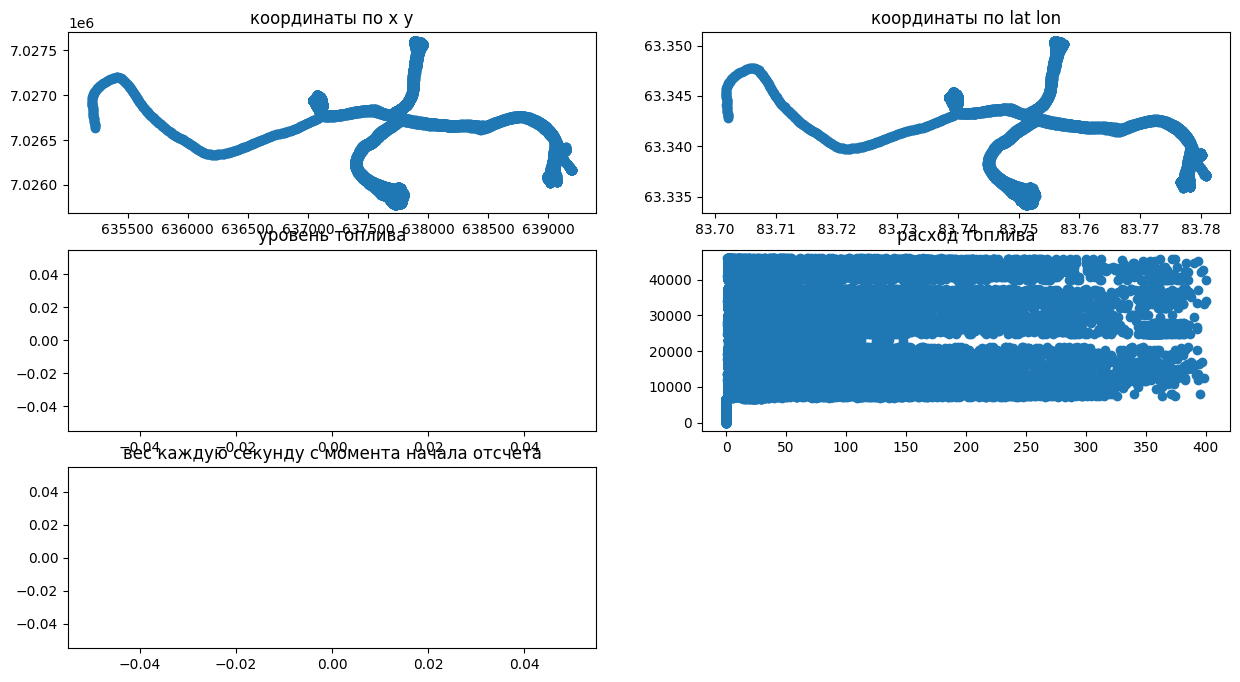

данные по самоcвалу 1125 при w_fl=1


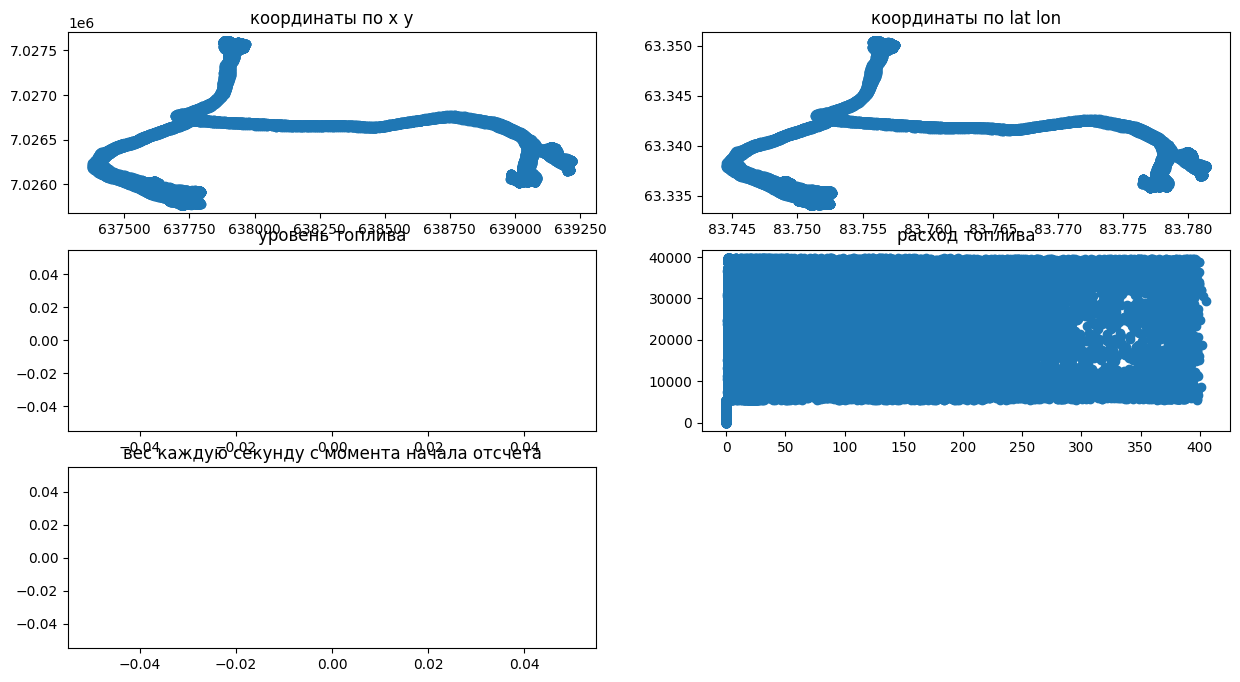

данные по самоcвалу 1126 при w_fl=0


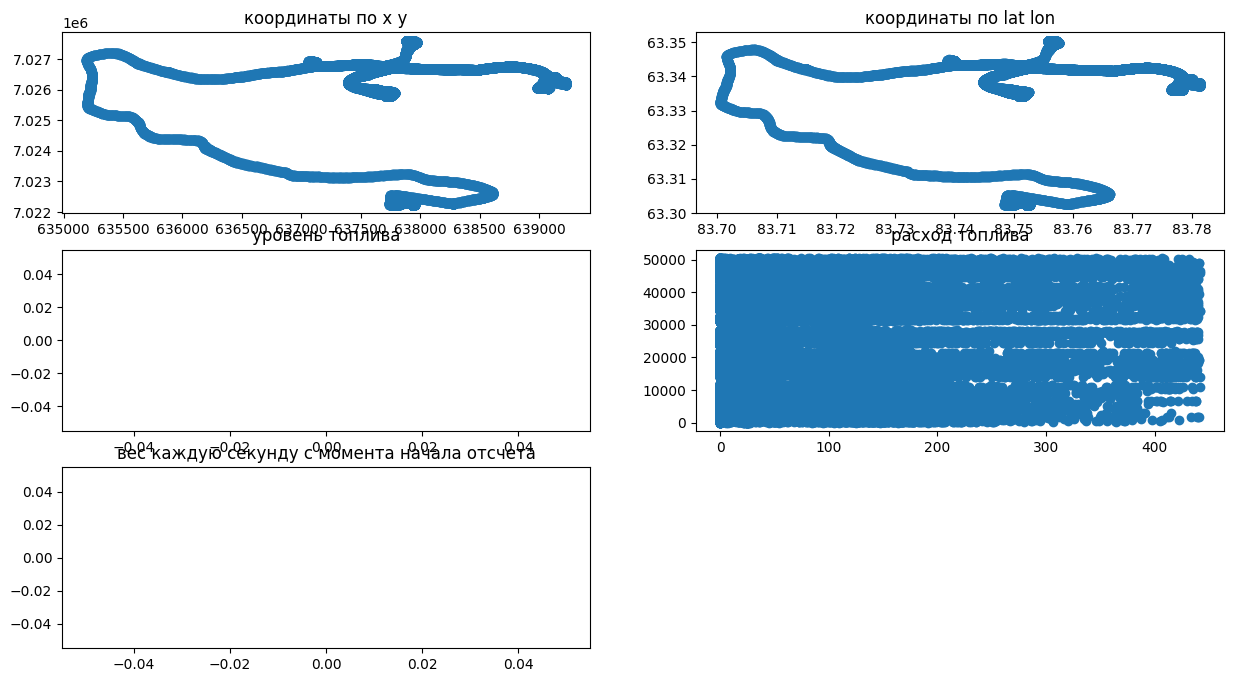

данные по самоcвалу 1126 при w_fl=1


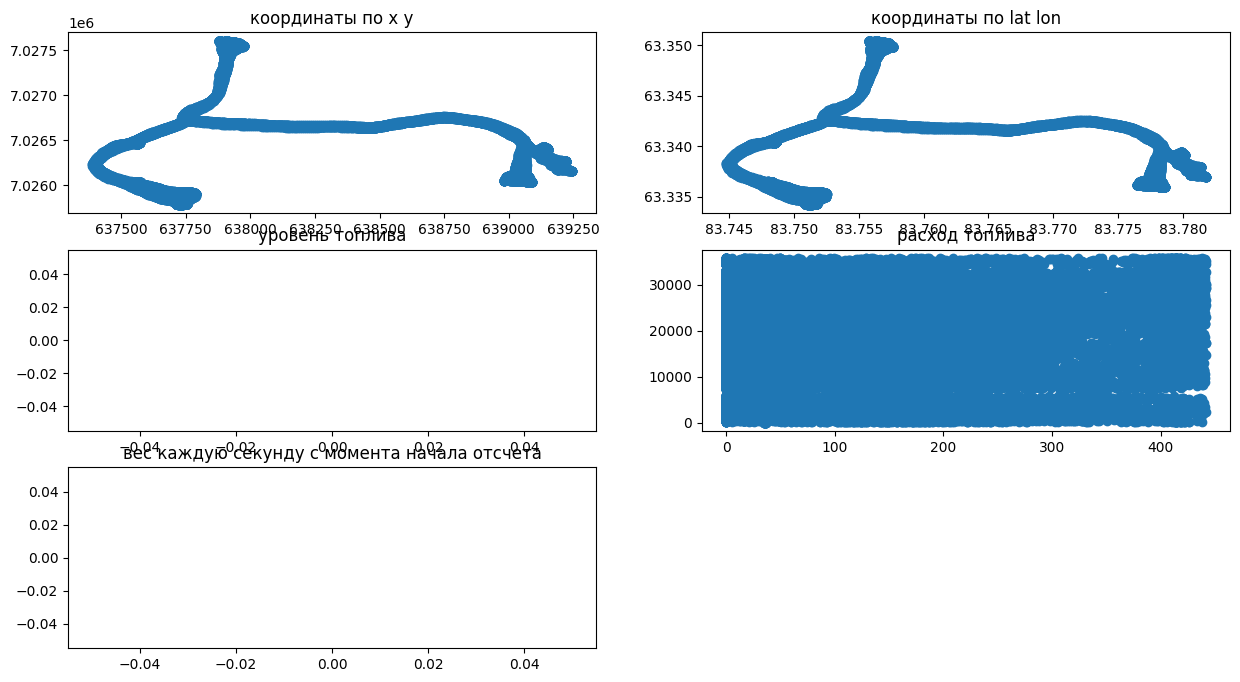

как видим проблемы с самосвалами 1124:1126,в 3 задании я объясню почему графики в таком виде и что я с этим буду делать


"\n# карта карьера закомменчена,так как я решил немного порисовать на ней ,и импортировал ее напрямую в коллаб\nx = tel['x']\ny = tel['y']\nplt.figure(figsize=(15,8))\nplt.title('Карта карьера')\nplt.scatter(x,y)\nplt.show()\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# читаем паркеты
tel = pd.read_parquet('./telemetry.parquet').sort_values(by='time', axis=0)
tel['time'] = pd.to_datetime(tel['time']).round('S')
weather = pd.read_parquet('./weather_hourly.parquet').sort_values(by='time', axis=0)
weather['time'] = pd.to_datetime(weather['time']).round('S')
# смотрим на них
print(tel.info())

# смотрим пропуски
print(tel.isnull().sum())
# хоть вы и рекомендовали заменить пропуски через .replace(np.NaN, method='ffill', inplace=True))
# я решил заняться этим только в 3 задании, пояснение моего решения будет в 3 задании.

# убираем выбросы по координатам (у самосвала 1121 есть аномальные координаты на 0 0)
tel = tel.loc[(tel['x'] > 1) & (tel['y'] > 1)]
# ну и заодно почистим те 955 записи, которые NaN ,так как вряд ли удастся корректно восстановить tripid
tel.dropna(subset=['tripid'],inplace=True)
# при просмотре данных по самосвалам: самосвал 1122 стоит на месте,
# а 1121 совершает какие-то странные движения(скорее всего проблема с GPS)
# так что я решил их убрать
tel = tel.loc[tel['objectid'] > 1122]

# так же при построении карты выяснилось что один из рейсов 1123 записался плохо,
# рейс с этим id решил удалить, так как с ним был небольшой дефект на итоговой карте
tel = tel.loc[(tel['tripid'] != 1003802.0)]

# надстройка ниже нужна для просмотра первых 3 рейсов,
# нас интересуют рейсы с id 1003627.0 и 1003629.0
# на них видно, что при w_fl= 0 самосвал с id 1124 не загружен, а при w_fl=1 вес самосвала меняется.
# tel = tel.loc[tel['tripid']<=1003629.0]

# строим графики для каждого самосвала
# i = id самосвала
# j = w_fl
obj_id = set(tel['objectid'])
print('по каким то причинам в ноутбуке съедаются названия графика,так что выводить пришлось обычном принтом')
for i in obj_id:
    for j in range(2):
        print(f'данные по самоcвалу {i} при w_fl={j}')
        tel1 = tel.loc[(tel['objectid']== i) & (tel['w_fl']==j)]
        x = tel1['x']
        y = tel1['y']
        lat = tel1['lat']
        lon = tel1['lon']
        fuel = tel1['fuel_tank_level']
        fuel_cons = tel1['fuel_cons']
        weight_min = tel1['weight_dynamic']
        plt.figure(figsize=(15,8))
        plt.title(str(i)+' при w_fl='+str(j))
        plt.subplot(3,2,1)
        plt.scatter(x,y)
        plt.title('координаты по х у')
        plt.subplot(3,2,2)
        plt.scatter(lon,lat)
        plt.title('координаты по lat lon')
        plt.subplot(3,2,3)
        plt.scatter(fuel,[i for i in range(len(fuel))])
        plt.title('уровень топлива')
        plt.subplot(3,2,4)
        plt.scatter(fuel_cons,[i for i in range(len(fuel_cons))])
        plt.title('расход топлива')
        plt.subplot(3,2,5)
        plt.scatter(weight_min,[i for i in range(len(weight_min))])
        plt.title('вес каждую секунду с момента начала отсчета')
        plt.show()

print('как видим проблемы с самосвалами 1124:1126,в 3 задании я объясню почему графики в таком виде и что я с этим буду делать')

'''
# карта карьера закомменчена,так как я решил немного порисовать на ней ,и импортировал ее напрямую в коллаб
x = tel['x']
y = tel['y']
plt.figure(figsize=(15,8))
plt.title('Карта карьера')
plt.scatter(x,y)
plt.show()
'''

### собственно карта карьера
красным омечено место,куда самосвалы приезжали только при w_fl = 1,скорее всего это одно из мест погрузок

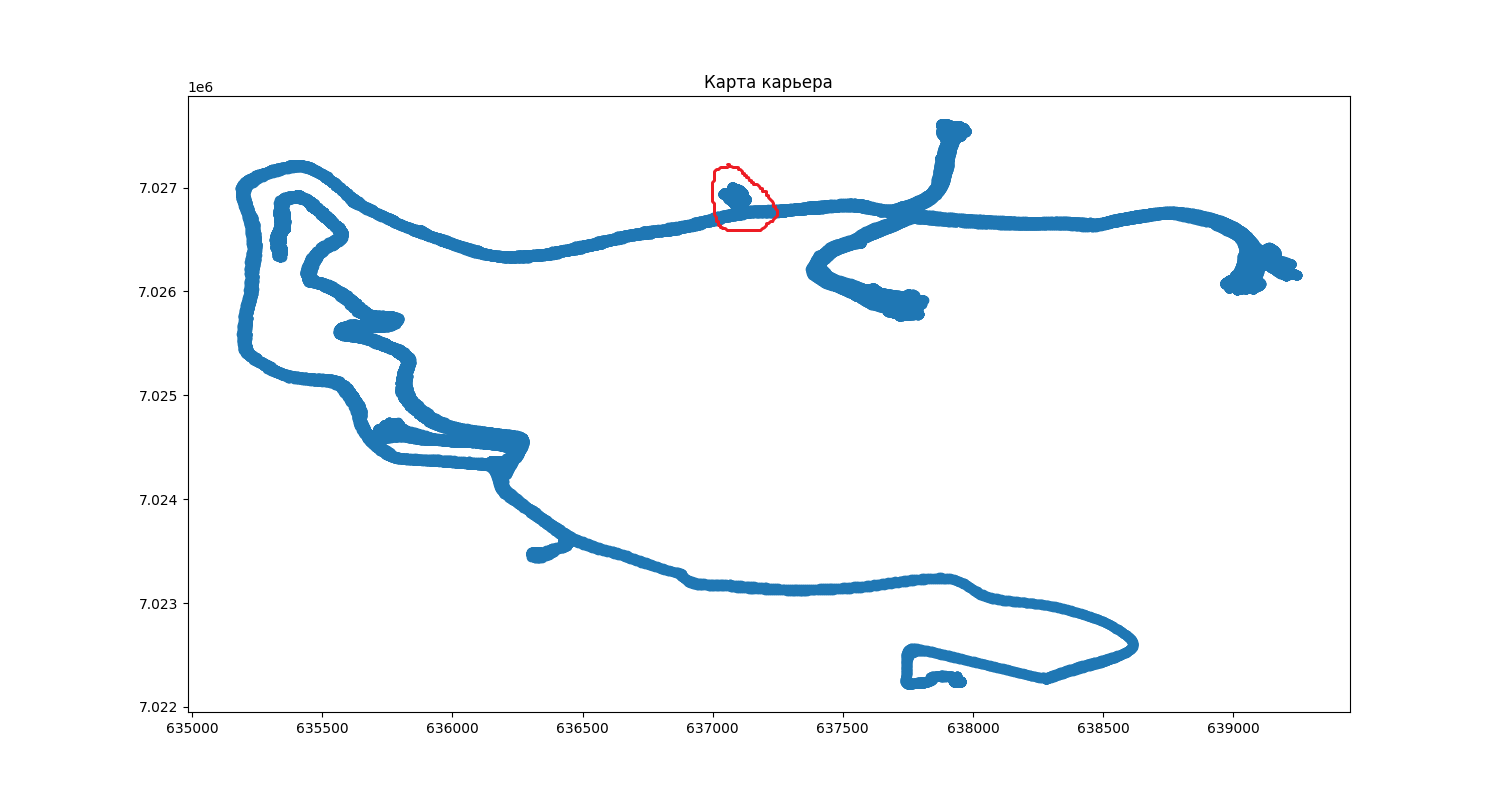

### графики по самосвалу 1123 с рейсовыми id 1003627 и 1003629  о которых говорилось выше

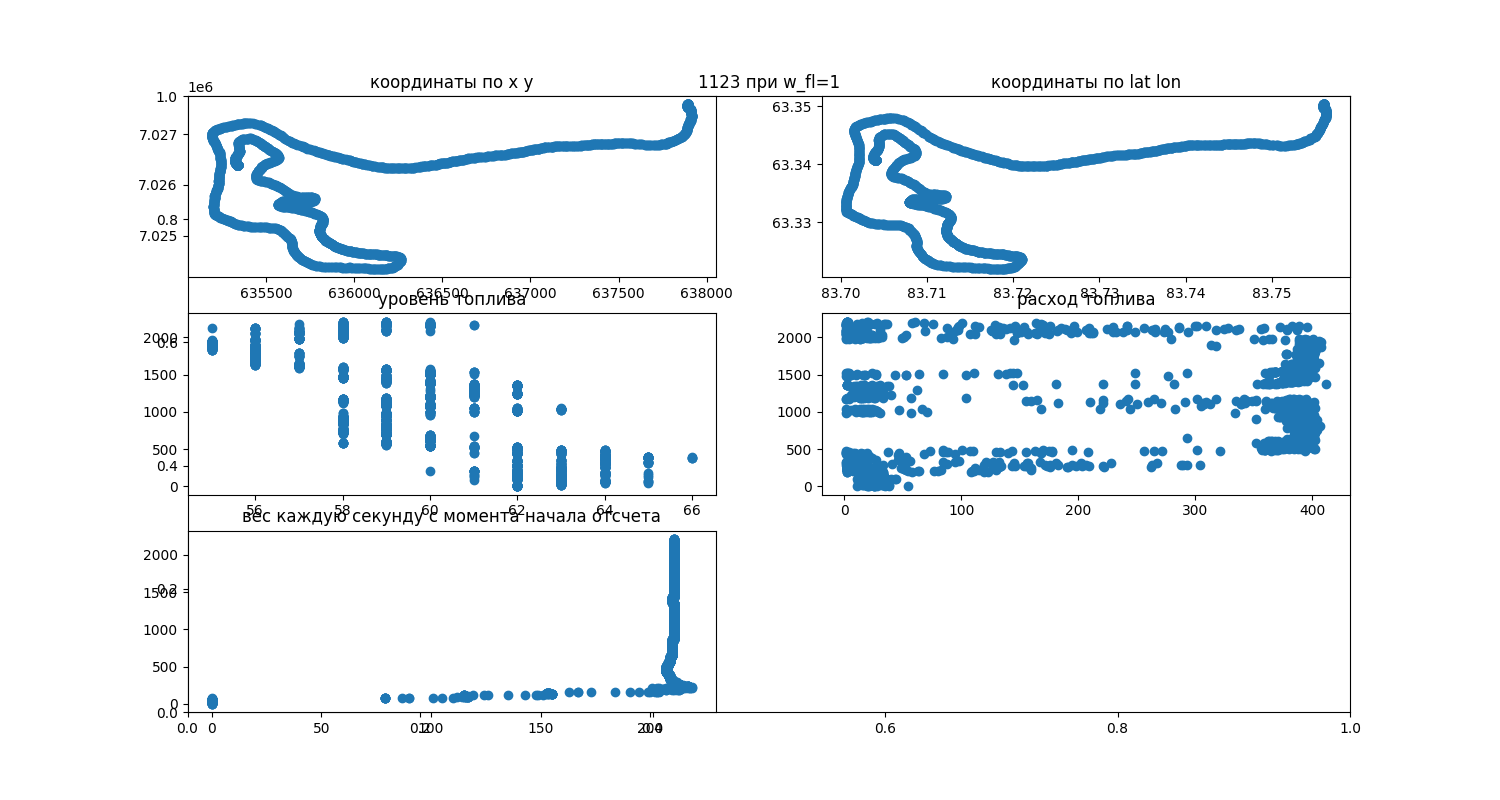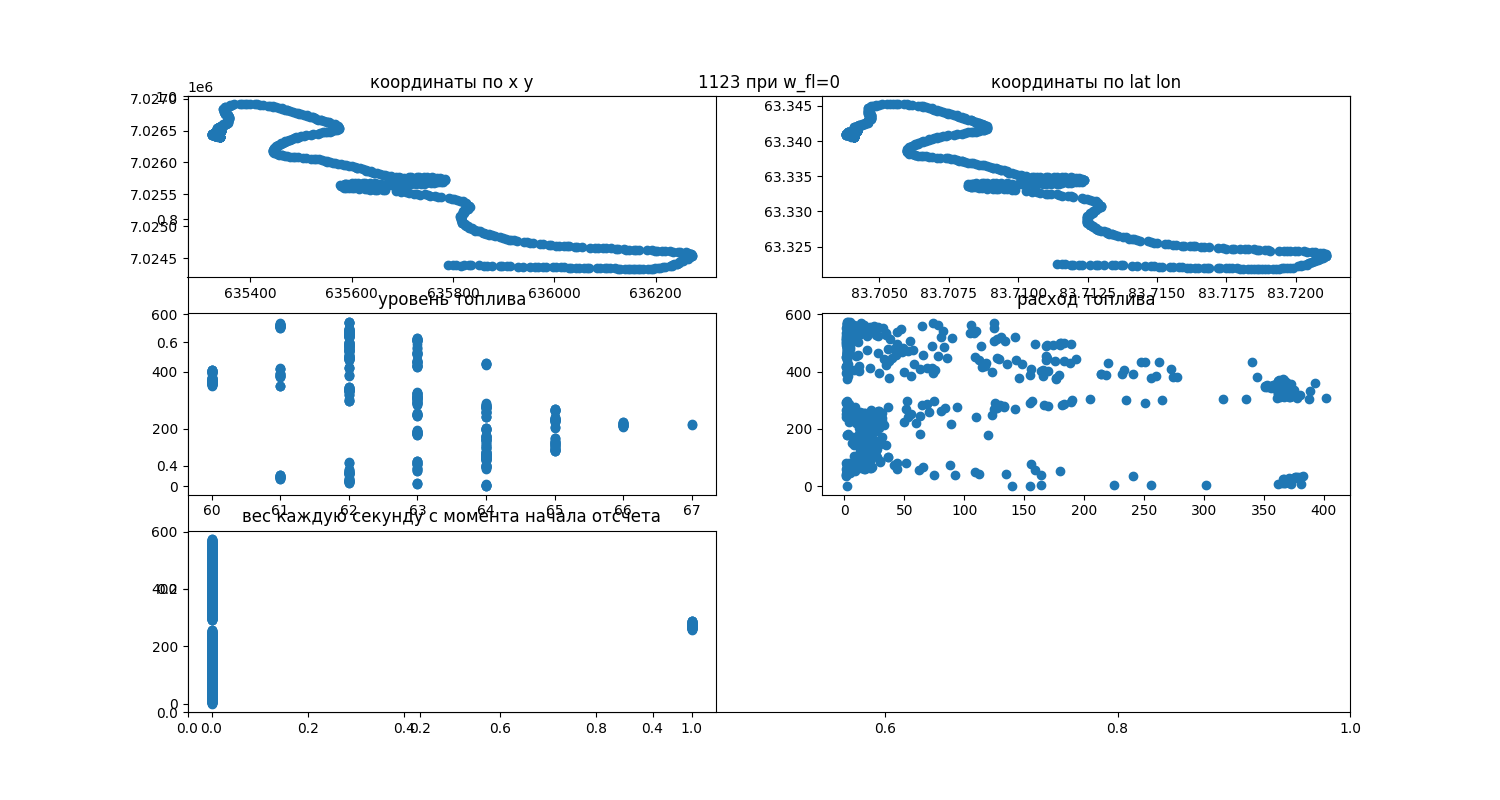

### выводы

судя по увиденным графикам при отметке w_fl = 1 самосвалы загружаются , а затем отправляются в рейс на выгрузку ,а при w_fl = 0 самосвал разгружаются и отправляются на погрузку.


при этом отсчет временем и w_fl  изменяются как только самосвал прибыл в зону погрузки/разгрузки.(то есть метка меняется как только самосвал встал на погрузку,и до последующего прибытия на разгрузку)

## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

objectid            1123.000000
hdop                   2.525890
speed                 16.744154
engine_speed                NaN
DQ_vertical_bump       0.000000
height                89.731083
dtype: float64
objectid            1124.000000
hdop                   7.037529
speed                 12.791666
engine_speed        1135.849790
DQ_vertical_bump       0.000000
height               266.987452
dtype: float64
objectid            1125.000000
hdop                   8.445042
speed                 13.657709
engine_speed         999.896761
DQ_vertical_bump       0.000000
height               264.803802
dtype: float64
objectid            1126.000000
hdop                   7.584820
speed                 13.430823
engine_speed        1161.572864
DQ_vertical_bump       0.000000
height               262.754274
dtype: float64


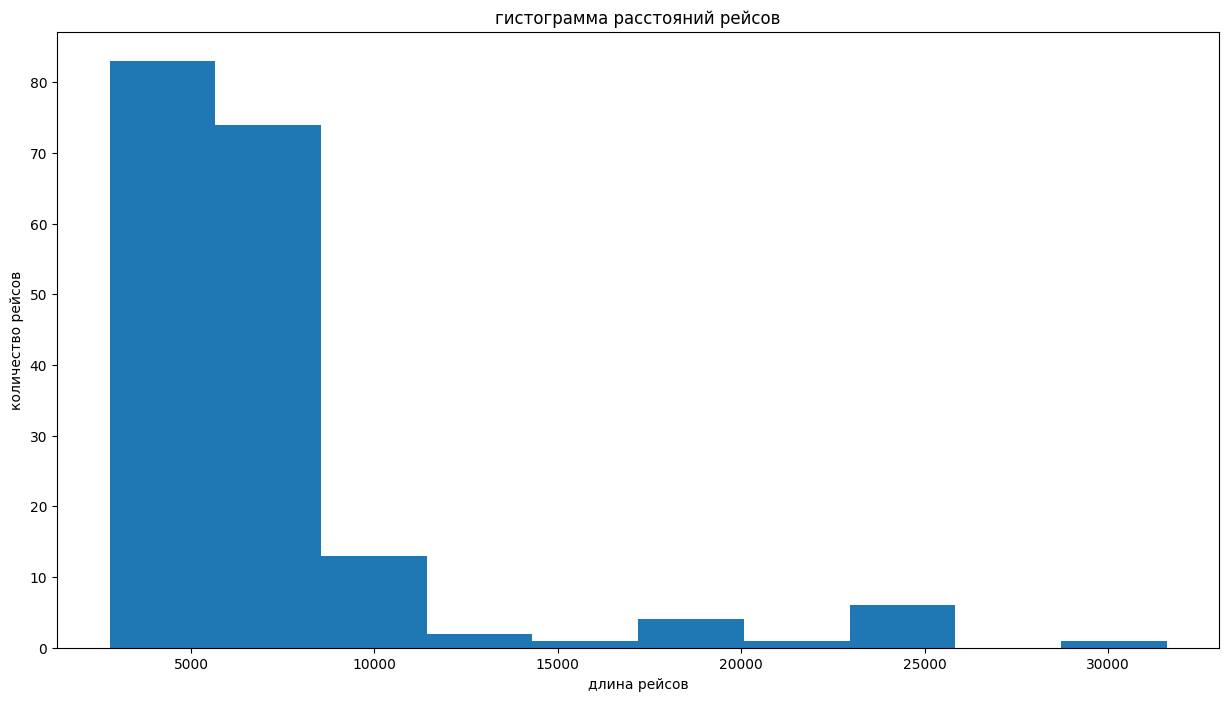

time      2023-11-08 00:00:00+07:00  2023-11-08 01:00:00+07:00  \
objectid                                                         
1123.0                    22.358631                  18.714639   
1124.0                    19.359444                  15.550194   
1125.0                    13.207333                  17.689444   
1126.0                    17.658694                  18.087889   

time      2023-11-08 02:00:00+07:00  2023-11-08 03:00:00+07:00  \
objectid                                                         
1123.0                    21.400921                  11.876650   
1124.0                    17.290861                  10.585278   
1125.0                    17.936111                  16.948139   
1126.0                    15.322750                  12.422889   

time      2023-11-08 04:00:00+07:00  2023-11-08 05:00:00+07:00  \
objectid                                                         
1123.0                    21.852048                  15.334617   
1124.0  

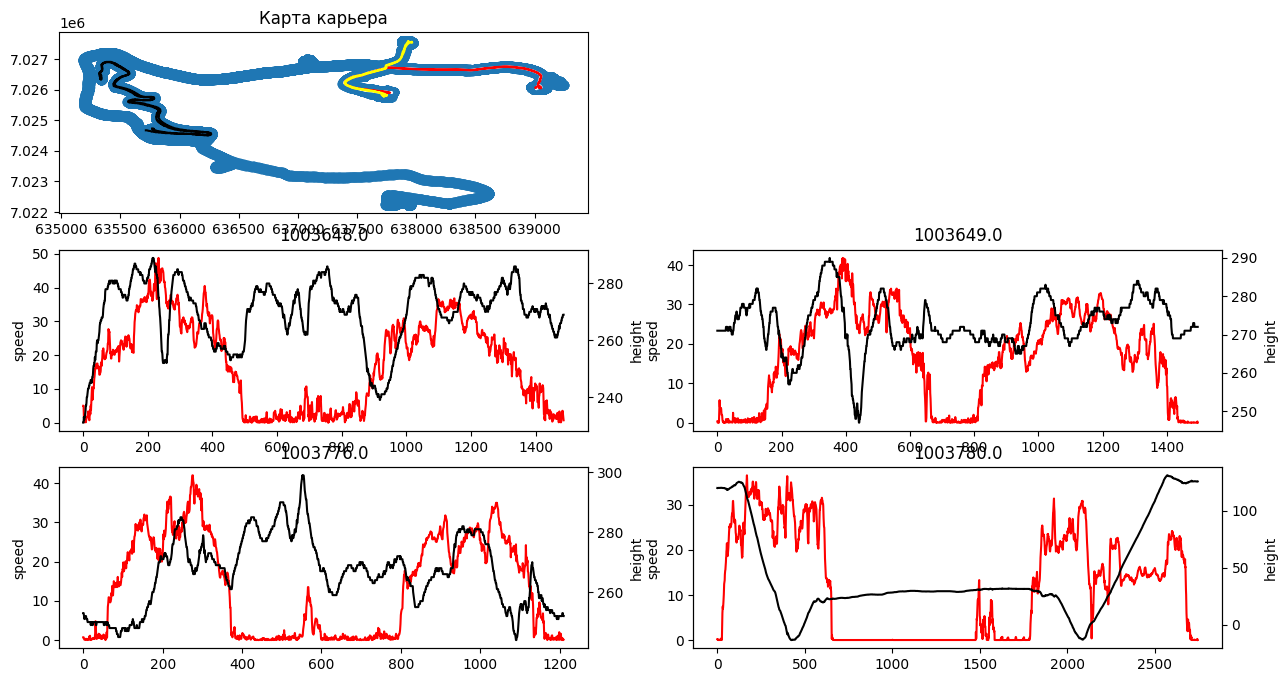

для проверки выведем самосвал,время и одну из колонок из weather
        objectid                       time  rain
3           1123  2023-11-08 00:00:00+07:00   0.0
7           1123  2023-11-08 00:00:01+07:00   0.0
14          1123  2023-11-08 00:00:03+07:00   0.0
18          1123  2023-11-08 00:00:04+07:00   0.0
22          1123  2023-11-08 00:00:05+07:00   0.0
...          ...                        ...   ...
335798      1126  2023-11-08 23:59:56+07:00   0.0
335799      1126  2023-11-08 23:59:57+07:00   0.0
335800      1126  2023-11-08 23:59:58+07:00   0.0
335801      1126  2023-11-08 23:59:59+07:00   0.0
335802      1126  2023-11-09 00:00:00+07:00   0.0

[335803 rows x 3 columns]


In [3]:
# выводим средние значения по указанным параметрам
params = ['objectid', 'hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height']
obj_id = set(tel['objectid'])
tel1 = tel[params]
for i in obj_id:
    tel2 = tel1.loc[tel1['objectid'] == i]
    print(tel2.mean())

# расстояние решил считать по евклиду в трехмерном пространстве
# многие tripid были значения Nan, пришлось очистить их от этого, иначе гистограмма выходила некорректной.
trip_id = set(tel.loc[tel['tripid'] > 0]['tripid'])
params = ['x', 'y', 'height']
hist = {}
for i in trip_id:
    tel1 = tel.loc[tel['tripid'] == i][params].to_numpy()
    tel2 = tel1[1:]
    tel2 = np.vstack([tel2, tel2[-1]])
    tel2 = np.square(tel2 - tel1)
    tel2 = tel2[:, 0] + tel2[:, 1] + tel2[:, 2]
    tel2 = np.sqrt(tel2)
    hist[i] = sum(tel2)
plt.figure(figsize=(15, 8))
plt.title('гистограмма расстояний рейсов')
plt.hist(list(hist.values()))
plt.xlabel('длина рейсов')
plt.ylabel('количество рейсов')
plt.show()
# строим таблицу средних скоростей по самосвалам
params = ['objectid', 'speed']
tel1 = tel.loc[tel['objectid'] == obj_id.pop()].resample('1H', on='time').mean()[params]
while obj_id:
    tel1 = pd.concat([tel1, tel.loc[tel['objectid'] == obj_id.pop()].resample('1H', on='time').mean()[params]])
table = pd.pivot_table(tel1, values='speed', index='objectid', columns='time')
# уберите комментирование, что бы посмотреть таблицу полностью
pd.set_option('display.max_columns', None)
print(table)

# отбираем 1 рейс для каждого самосвала
obj_id = set(tel['objectid'])
tel2 = []
for i in obj_id:
    tel1 = tel.loc[tel['objectid'] == i]
    trip_id = set(tel1.loc[tel1['tripid'] > 0]['tripid']).pop()
    tel1 = tel1.loc[tel1['tripid'] == trip_id]
    if len(tel2) > 0:
        tel2 = pd.concat([tel2, tel1])
    else:
        tel2 = tel1.copy()
trip_id = list(set(tel2['tripid']))
# строим карту карьера
x = tel['x']
y = tel['y']
plt.figure(figsize=(15, 8))
plt.subplot(3, 2, 1)
plt.scatter(x, y)
plt.title('Карта карьера')
color = ['white', 'red', 'yellow', 'black']
for i in range(len(trip_id)):
    # при каждой итерации наносим маршрут самосвала на карту
    plt.subplot(3, 2, 1)
    x = tel2.loc[tel2['tripid'] == trip_id[i]]['x']
    y = tel2.loc[tel2['tripid'] == trip_id[i]]['y']
    speed = tel2.loc[tel2['tripid'] == trip_id[i]]['speed']
    height = tel2.loc[tel2['tripid'] == trip_id[i]]['height']
    time = tel2.loc[tel2['tripid'] == trip_id[i]]['time']
    plt.plot(x, y, c=color[i], label=trip_id[i])
    # затем строим график зависимости скорости и высоты от времени
    # если оставлять тип datetime64, то значения все равно не влезали в график,
    # так что решил отразить посекундно с начала рейса
    plt.subplot(3, 2, 3 + i)
    plt.title(trip_id[i])
    plt.plot([i for i in range(len(speed))], speed, c=color[1])
    plt.ylabel('speed')
    plt.twinx()
    plt.plot([i for i in range(len(speed))], height, c=color[3])
    plt.ylabel('height')
print('на графике белый и красный маршрут почти идентичны,поэтому белый маршрут плохо виден')
plt.show()

# объединяем телеметрию с погодой
tel = pd.merge(tel, weather, how='left', on='time')
# поскольку датчики погоды регистрируют только раз в час, то заполняем пропуски последним корректным значением
for i in weather.columns:
    tel[i] = tel[i].replace(np.NaN, method='bfill')
print('для проверки выведем самосвал,время и одну из колонок из weather')
print(tel[['objectid', 'time', 'rain']].sort_values(['objectid', 'time'], axis=0))


## Задание 3

**Обучить модель для предсказания значений скорости самосвала (колонка speed)**
* Можно (и даже нужно) генерировать дополнительные фичи.
* Выполнить необходимые (на Ваш взгляд) преобразования датасета.
* Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики
* Обучить несколько моделей и сравнить их. Интерпретировать результаты.

### обработка данных из задания 1

In [4]:
# сперва займемся пропусками в колонках
# изначально я хотел сделать что-то вроде:
'''
params = ['engine_speed','fuel_tank_level','weight_dynamic']
for i in params:
    tel[i].replace(np.NaN, method='ffill', inplace=True)
'''
# которое вы рекомендовали сделать еще в первом задании
# однако как выяснилось пропуски отсутствуют у конкретных самосвалов, что видно на графиках
# а значит при выполнении кода выше к самосвалам 1124,1125 и 1126 просто подставились бы значения от других самосвалов,
# а конкретно самосвала 1123,
# а в engine_speed самосвала 1123 поставились значения одного из этих трех.
# например если поставить код выше в самое начало, то после будет заметно что на графиках к 1 заданию в 'fuel_tank_level'
# уровень топлива у самосвалов абсолютно одинаково повторяется, просто с небольшой погрешностью.
# для проверки этого я написал код ниже, и как видите после него количество Nan не уменьшилось.
params = ['engine_speed','fuel_tank_level','weight_dynamic']
obj_id = sorted(set(tel['objectid']))
print(tel.isnull().sum())
for i in params:
    for j in obj_id:
        tel[i].loc[tel['objectid']==j].replace(np.NaN, method='ffill', inplace=True)
print(tel.isnull().sum())
print(f'как видим надо заменить значения в {params},а так же что то сделать с 603 записями с NaN в tripid')

# так что я решил немного заморочиться:
# я думаю что подставить вместо пропусков значения, предсказанные нейросетью лучше,
# чем просто заменить их значениями самосвала с другого маршрута.
# так что план следующий:
# 1. обрезать из tel 'engine_speed','fuel_tank_level','weight_dynamic' и обучить на этом нейросеть
# 2. обучить нейросеть на самосвалах 24,25,26 и предсказать engine_speed для самосвала 1123
# 3. предсказать для самосвалов 1124, 1125, 1126 пропущенные значения через самосвал 1123
# и подставить их вместо NaN в обрезанную ранее часть
# 4. присоединить обрезанную часть и по полноценным данным предсказывать скорость.

print('помотрим на данные')
print(tel.info())
print('как видим у нас есть datetime64 в time и object в precipType')
print('переводим их  в числовые значения, время переведем в отсчет секунд,а object в категориальные метки')
tel['time'] = [i for i in range(len(tel))]
labels = list(set(tel['precipType']))
tel['precipType'].replace(labels, [i for i in range(len(labels))], inplace=True)
print('''так же решил удалить tripid(objectid и driverid  могут отражать индивидуальные особенности машины и самосвала),
а вот tripid  может отражать изношенность машины(чем больше рейсов=больше срок эксплуатации, однако в рамках одного дня
это явно излишне) и колонки (x y) ,так как они имеют прямую корреляцию с (lat lon) ''')
tel.drop(['tripid','x','y'],inplace=True,axis=1)

# так же сохраним данные в отдельную переменную на этом этапе,
# это понадобится при проверке эффективности моего решения в конце
tel_orig = tel.copy()

print('посмотрим на данные еще раз')
print(tel.isnull().sum())
print('теперь можно приступать к формированию датасетов')
#
# создаем датасеты x(tel без params) и y для предсказаний
y = tel[params]
y.fillna(0, inplace=True)
tel.drop(columns=params, inplace=True, axis=1)
print('проверяем что получилось')
print(tel['precipType'])

objectid                     0
time                         0
lat                          0
lon                          0
speed                        0
height                       0
fuel_cons                    0
engine_speed             77203
hdop                         0
DQ_vertical_bump             0
accelerator_position         0
fuel_tank_level         258600
weight_dynamic          258600
tripid                       0
weight                       0
driverid                     0
w_fl                         0
x                            0
y                            0
precipIntensity              0
precipProbability            0
temperature                  0
apparentTemperature          0
dewPoint                     0
humidity                     0
pressure                     0
windSpeed                    0
windGust                     0
windBearing                  0
cloudCover                   0
visibility                   0
precipType                   0
rain    

<ipython-input-4-dc1fd58842b9>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


### создание модели

In [5]:
# переходим к созданию модели
import keras
from keras import layers, metrics, optimizers, losses, callbacks

# указываем гиперпараметры
EPOCHS = 50
BATCH = 32
lr = 0.05
valid_split = 0.8

# на тестах лучше всего себя показали функции активации с тангенсом и сигмоидой
# однако при предсказании fuel_tank_level сигмоида сбивала модель,
# поэтому я в итоге решил оставить ансамбль из тангенсов
# основная модель: ансамбль с разными функциями активации
def build_model(inp, output):
    q = layers.Input(inp)
    q1 = layers.Dense(inp * 10, activation='tanh')(q)
    q1 = layers.Dense(inp * 10)(q1)
    q1 = layers.Dense(output)(q1)
    q2 = layers.Dense(inp * 10, activation='tanh')(q)
    q2 = layers.Dense(inp * 10)(q2)
    q2 = layers.Dense(output)(q2)
    q2 = layers.Add()([q1, q2])
    model1 = keras.Model(inputs=q, outputs=q2)
    return model1

# упрощенная модельБ использовалась при тестировании
def build_model1(inp, output):
    model1 = keras.Sequential([
        layers.Dense(inp),
        layers.Dense(inp*10, activation='tanh'),
        layers.Dense(inp * 10),
        layers.Dense(output)
    ])
    return model1

### предсказываем engine_speed

In [6]:
# создаем датасеты для предсказывания engine_speed через самосвалы 1124_6
params1 = ['speed', 'accelerator_position', 'fuel_cons',]
x1124_6 = tel.loc[tel['objectid'] != 1123][params1]
y1124_6 = y.loc[tel['objectid'] != 1123]['engine_speed']
# создаем объект нормализации
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x1124_6)
print(y1124_6)

# нормализуем данные
x1124_6 = normalizer(x1124_6)
# создаем модель
mod1 = build_model(len(params1), 1)
# поскольку перед нами калссическая задача регрессии ,
# то для штрафов я решил использовать mse, так как меня интересуют наиболее точные предсказания
# но для оценки точности mae , дабы оценить разброс точности в абсолютной величине
mod1.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
             loss=losses.mse,
             metrics=metrics.mae)
# используем коллбэки для сохранения лучшей модели и подбора lr при выходе на плато.
callback = [
    callbacks.ModelCheckpoint('./DS/mod1', monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='mean_absolute_error')
]
print('тренируем  модель на  engine_speed')
mod1.fit(x1124_6, y1124_6, epochs=EPOCHS, validation_split=valid_split, shuffle=True, batch_size=BATCH,
         callbacks=callback)
# загружаем лучшую сохраненную модель
mod1 = keras.models.load_model('./DS/mod1')
# проверяем ее
mod1.evaluate(x1124_6, y1124_6)
x1123 = normalizer(tel.loc[tel['objectid'] == 1123][params1])
print('предсказываем  engine_speed')
predict1 = mod1.predict(x1123).reshape(-1).astype(int)
# вставляем результаты по индексу
idx = y.loc[tel['objectid'] == 1123].index
for i in range(len(idx)):
    y['engine_speed'].iloc[idx[i]] = max(0,predict1[i])
tel['engine_speed'] = y['engine_speed']

0            0.00
1          994.25
2         1100.00
4         1100.00
5            0.00
           ...   
335798     686.00
335799     683.00
335800     699.00
335801     703.00
335802     701.00
Name: engine_speed, Length: 258600, dtype: float64
тренируем  модель на  engine_speed
Epoch 1/50
1617/1617 [==============================] - 16s 10ms/step - loss: 131933.5469 - mean_absolute_error: 293.5222 - val_loss: 45918.0469 - val_mean_absolute_error: 149.6260 - lr: 0.0500
Epoch 2/50
1617/1617 [==============================] - 13s 8ms/step - loss: 112523.2109 - mean_absolute_error: 261.9489 - val_loss: 122898.4688 - val_mean_absolute_error: 287.6345 - lr: 0.0500
Epoch 3/50
1617/1617 [==============================] - 12s 7ms/step - loss: 108580.2656 - mean_absolute_error: 255.6042 - val_loss: 76523.0859 - val_mean_absolute_error: 186.0129 - lr: 0.0500
Epoch 4/50
1617/1617 [==============================] - 13s 8ms/step - loss: 105125.5312 - mean_absolute_error: 249.1416 - val_loss: 48

<ipython-input-6-3eca1efb86e2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['engine_speed'].iloc[idx[i]] = max(0,predict1[i])


### предсказываем  weight_dynamic

In [7]:
# теперь нужно предсказать fuel_tank_level и weight_dynamic для остальных самосвалов через самосвал 1123
# решения для fuel_tank_level и weight_dynamic практически идентичны,просто предсказываются разные параметры
# начнем с weight_dynamic
params1 = ['speed', 'accelerator_position', 'fuel_cons', 'weight', 'w_fl']
x1123 = tel.loc[tel['objectid'] == 1123][params1]
y1123 = y.loc[tel['objectid'] == 1123]['weight_dynamic']
x1124_6 = tel.loc[tel['objectid'] != 1123][params1]
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x1123)
print(y1123)

x1123 = normalizer(x1123)
mod1 = build_model(len(params1), 1)
mod1.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
             loss=losses.mse,
             metrics=metrics.mae)
callback = [
    callbacks.ModelCheckpoint('./DS/mod2', monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='mean_absolute_error')
]
print('обучаем модель на  weight_dynamic')
mod1.fit(x1123, y1123, epochs=EPOCHS, validation_split=valid_split, shuffle=True, batch_size=BATCH, callbacks=callback)

mod1 = keras.models.load_model('./DS/mod2')
print('проверяем модель')
mod1.evaluate(x1123, y1123)
x1124_6 = normalizer(x1124_6)
predict1 = mod1.predict(x1124_6).reshape(-1).astype(int)
idx = y.loc[tel['objectid'] != 1123].index
for i in range(len(idx)):
    y['weight_dynamic'].iloc[idx[i]] = max(0,predict1[i])
tel['weight_dynamic'] = y['weight_dynamic']
print(tel.loc[tel['objectid'] != 1123]['weight_dynamic'])

3           0.0
7           0.0
14          0.0
18          0.0
22          0.0
          ...  
335726    211.0
335728    207.0
335730    204.0
335732    202.0
335734    199.0
Name: weight_dynamic, Length: 77203, dtype: float64
обучаем модель на  weight_dynamic
Epoch 1/50
483/483 [==============================] - 6s 11ms/step - loss: 1252.5580 - mean_absolute_error: 19.4196 - val_loss: 1168.0521 - val_mean_absolute_error: 17.7661 - lr: 0.0500
Epoch 2/50
483/483 [==============================] - 4s 7ms/step - loss: 907.4828 - mean_absolute_error: 14.9934 - val_loss: 1547.5952 - val_mean_absolute_error: 24.5884 - lr: 0.0500
Epoch 3/50
483/483 [==============================] - 4s 9ms/step - loss: 862.0189 - mean_absolute_error: 13.9076 - val_loss: 1007.3209 - val_mean_absolute_error: 14.0701 - lr: 0.0500
Epoch 4/50
483/483 [==============================] - 4s 8ms/step - loss: 830.3134 - mean_absolute_error: 12.9661 - val_loss: 1215.9307 - val_mean_absolute_error: 22.6623 - lr: 0.0500


<ipython-input-7-cb48bb19dd58>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['weight_dynamic'].iloc[idx[i]] = max(0,predict1[i])


0           0.0
1         176.0
2         124.0
4         128.0
5           0.0
          ...  
335798    215.0
335799    215.0
335800    215.0
335801    215.0
335802    215.0
Name: weight_dynamic, Length: 258600, dtype: float64


### предсказываем fuel_tank_level

In [8]:
# а теперь fuel_tank_level
params1 = ['speed', 'accelerator_position', 'fuel_cons', 'weight', 'w_fl','fuel_cons']
x1123 = tel.loc[tel['objectid'] == 1123][params1]
y1123 = y.loc[tel['objectid'] == 1123]['fuel_tank_level']
x1124_6 = tel.loc[tel['objectid'] != 1123][params1]
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x1123)
print(y1123)

x1123 = normalizer(x1123)
mod1 = build_model(len(params1), 1)
mod1.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
             loss=losses.mse,
             metrics=metrics.mae)
callback = [
    callbacks.ModelCheckpoint('./DS/mod3', monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='mean_absolute_error')
]
print('обучаем модель на  fuel_tank_level')
mod1.fit(x1123, y1123, epochs=EPOCHS, validation_split=valid_split, shuffle=True, batch_size=BATCH, callbacks=callback)

mod1 = keras.models.load_model('./DS/mod3')
print('проверяем модель')
mod1.evaluate(x1123, y1123)
x1124_6 = normalizer(x1124_6)
predict1 = mod1.predict(x1124_6).reshape(-1).astype(int)
idx = y.loc[tel['objectid'] != 1123].index
for i in range(len(idx)):
    y['fuel_tank_level'].iloc[idx[i]] = max(0,predict1[i])
tel['fuel_tank_level'] = y['fuel_tank_level']
print(tel.loc[tel['objectid'] != 1123]['fuel_tank_level'])

3         64.0
7         64.0
14        64.0
18        64.0
22        64.0
          ... 
335726    95.0
335728    95.0
335730    95.0
335732    95.0
335734    94.0
Name: fuel_tank_level, Length: 77203, dtype: float64
обучаем модель на  fuel_tank_level
Epoch 1/50
483/483 [==============================] - 6s 11ms/step - loss: 122.5150 - mean_absolute_error: 7.2444 - val_loss: 317.0919 - val_mean_absolute_error: 14.6084 - lr: 0.0500
Epoch 2/50
483/483 [==============================] - 3s 7ms/step - loss: 43.2631 - mean_absolute_error: 4.2231 - val_loss: 747.1304 - val_mean_absolute_error: 22.7549 - lr: 0.0500
Epoch 3/50
483/483 [==============================] - 4s 7ms/step - loss: 38.3959 - mean_absolute_error: 3.7424 - val_loss: 331.9459 - val_mean_absolute_error: 14.9403 - lr: 0.0500
Epoch 4/50
483/483 [==============================] - 6s 13ms/step - loss: 32.9696 - mean_absolute_error: 3.1950 - val_loss: 334.3739 - val_mean_absolute_error: 15.5053 - lr: 0.0500
Epoch 5/50
483/483 [

<ipython-input-8-99cee546d460>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['fuel_tank_level'].iloc[idx[i]] = max(0,predict1[i])


0         46.0
1         41.0
2         58.0
4         58.0
5         46.0
          ... 
335798    41.0
335799    41.0
335800    41.0
335801    41.0
335802    41.0
Name: fuel_tank_level, Length: 258600, dtype: float64


### предсказываем speed

In [9]:
# ну а теперь перейдем собственно к заданию
# я сравню на одной модели данные, полученные мной,
# и через автозаполнение пропусков с помощью tel.replace(np.NaN, method='ffill', inplace=True)
# создаем датасеты
tel_orig.replace(np.NaN, method='bfill', inplace=True)
tel_orig.dropna(inplace=True)
y_orig = tel_orig['speed']
tel_orig.drop('speed', inplace=True, axis=1)
y = tel['speed']
tel.drop('speed', inplace=True, axis=1)
# параметры погоды слишком тяжело использовать для предсказания скорости,поэтому я решил их отбросить
# в целом данных за один день в принципе мало что бы их правильно интерпретировать,
# и на практике самыми полезными параметрами для предсказания скорости являются accelerator_position и engine_speed,все остальные либо не влияют(их нет в params1)
# либо влияют минимально
params1 = ['accelerator_position','weight_dynamic','weight','w_fl', 'engine_speed','fuel_cons']
tel1 = tel[params1]
tel_orig = tel_orig[params1]
# проводим нормализацию отобранных данных
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(tel1)
tel1 = normalizer(tel1)
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(tel_orig)
tel_orig = normalizer(tel_orig)

In [10]:
# вначале оценим на сгенерированных данных
mod1 = build_model(len(params1), 1)
mod1.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
             loss=losses.mse,
             metrics=metrics.mae)
callback = [
    callbacks.ModelCheckpoint('./DS/mod_x1', monitor='val_mean_absolute_error', save_best_only=True,
                              save_weights_only=True),
    callbacks.ReduceLROnPlateau(monitor='mean_absolute_error')
]
print('предсказываем  по моим данным')
history1 = mod1.fit(tel1, y, epochs=EPOCHS, validation_split=valid_split, shuffle=True, batch_size=BATCH,
                    callbacks=callback)

предсказываем  по моим данным
Epoch 1/50
2099/2099 [==============================] - 17s 8ms/step - loss: 121.3223 - mean_absolute_error: 8.6185 - val_loss: 126.6657 - val_mean_absolute_error: 9.1708 - lr: 0.0500
Epoch 2/50
2099/2099 [==============================] - 16s 7ms/step - loss: 102.6158 - mean_absolute_error: 7.8743 - val_loss: 146.4149 - val_mean_absolute_error: 9.7766 - lr: 0.0500
Epoch 3/50
2099/2099 [==============================] - 15s 7ms/step - loss: 98.7977 - mean_absolute_error: 7.5559 - val_loss: 188.8404 - val_mean_absolute_error: 11.0046 - lr: 0.0500
Epoch 4/50
2099/2099 [==============================] - 25s 12ms/step - loss: 91.4149 - mean_absolute_error: 7.3165 - val_loss: 97.7059 - val_mean_absolute_error: 8.1467 - lr: 0.0500
Epoch 5/50
2099/2099 [==============================] - 25s 12ms/step - loss: 91.2263 - mean_absolute_error: 7.2468 - val_loss: 91.8871 - val_mean_absolute_error: 7.1788 - lr: 0.0500
Epoch 6/50
2099/2099 [==============================

In [11]:
# теперь оценим на автозаполненных
mod2 = build_model(len(params1), 1)
mod2.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
             loss=losses.mse,
             metrics=metrics.mae)
callback = [
    callbacks.ModelCheckpoint('./DS/mod_x2', monitor='val_mean_absolute_error', save_best_only=True,
                              save_weights_only=True),
    callbacks.ReduceLROnPlateau(monitor='mean_absolute_error')
]
print('предсказываем  по автозаполненным данным')
history2 = mod2.fit(tel_orig, y_orig, epochs=EPOCHS, validation_split=valid_split, shuffle=True, batch_size=BATCH,
                    callbacks=callback)

предсказываем  по автозаполненным данным
Epoch 1/50
2099/2099 [==============================] - 16s 7ms/step - loss: 147.4524 - mean_absolute_error: 10.0683 - val_loss: 112.6980 - val_mean_absolute_error: 8.5537 - lr: 0.0500
Epoch 2/50
2099/2099 [==============================] - 26s 12ms/step - loss: 132.0476 - mean_absolute_error: 9.3357 - val_loss: 171.8143 - val_mean_absolute_error: 10.6634 - lr: 0.0500
Epoch 3/50
2099/2099 [==============================] - 26s 12ms/step - loss: 127.7512 - mean_absolute_error: 9.1351 - val_loss: 173.6615 - val_mean_absolute_error: 10.6107 - lr: 0.0500
Epoch 4/50
2099/2099 [==============================] - 26s 12ms/step - loss: 126.1177 - mean_absolute_error: 9.0720 - val_loss: 154.9119 - val_mean_absolute_error: 10.3263 - lr: 0.0500
Epoch 5/50
2099/2099 [==============================] - 26s 12ms/step - loss: 124.2798 - mean_absolute_error: 8.9958 - val_loss: 154.6945 - val_mean_absolute_error: 10.2143 - lr: 0.0500
Epoch 6/50
2099/2099 [========

минимальный лосс и минимальное mae по сгенерированным данным
79.7442398071289 6.410114288330078
посмотрим как модель справится с датасетом в целом)
10494/10494 [==============================] - 17s 2ms/step - loss: 92.7714 - mean_absolute_error: 6.9754

минимальный лосс и минимальное mae по автозаполненным данным
112.69800567626953 8.553662300109863
посмотрим как модель справится с датасетом в целом)
10492/10492 [==============================] - 17s 2ms/step - loss: 192.4371 - mean_absolute_error: 10.9082



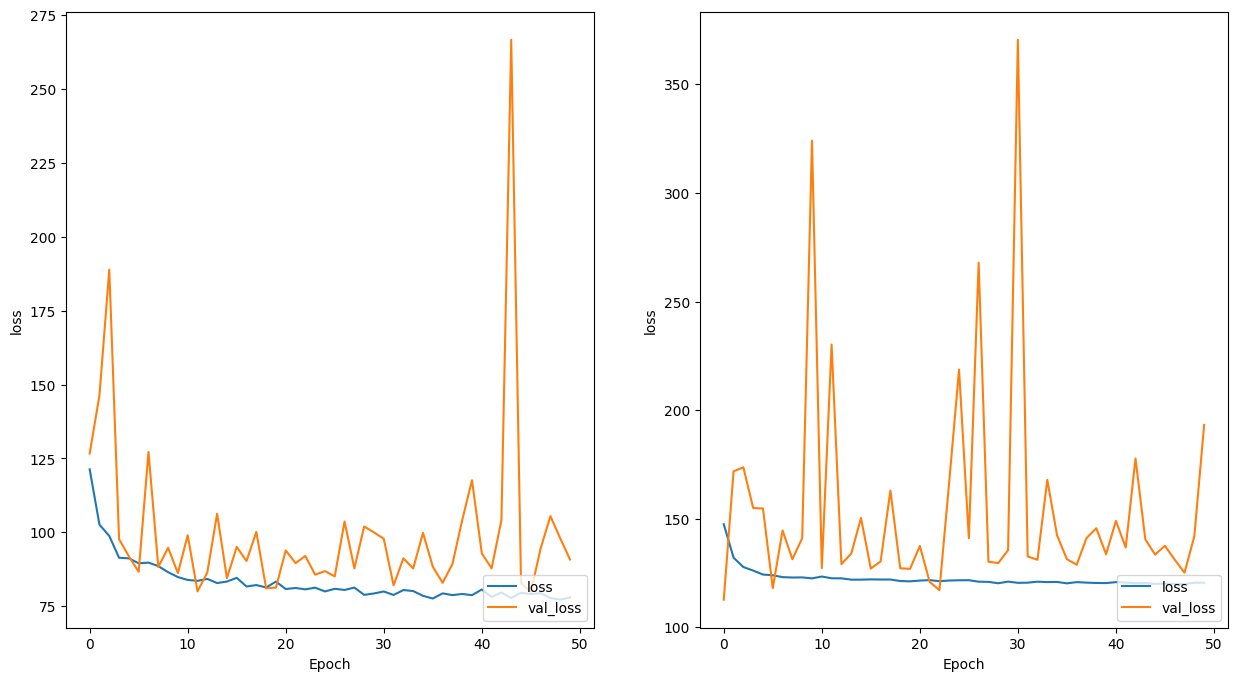

In [12]:
# просмотр графиков и результаты
print('минимальный лосс и минимальное mae по сгенерированным данным')
print(min(history1.history['val_loss']), min(history1.history['val_mean_absolute_error']))
print('посмотрим как модель справится с датасетом в целом)')
mod1.evaluate(tel1,y)
print()
print('минимальный лосс и минимальное mae по автозаполненным данным')
print(min(history2.history['val_loss']), min(history2.history['val_mean_absolute_error']))
print('посмотрим как модель справится с датасетом в целом)')
mod2.evaluate(tel_orig,y_orig)
print()
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()

как видно на графиках, на сгенерированных данных лосс значительно ниже,а точность выше ,относительно автозаполненных(примерно на 30-40%). Да и разброс его в целом меньше.Так что это как минимум было не зря)

хотя на самом деле не могу сказать, что доволен обработкой данных,
по хорошему здесь можно было сделать следующее:
1.   выделить координаты ,когда fuel_tank_level повышается и созадть отдельный столбец "находится на заправке" ,это бы повысило точность предсказания fuel_tank_level(хотя и вряд ли сильно отразится на точности предсказани speed)
2.   усреднить показатели по fuel_tank_level.на графиках заметны сильные колебания датчика вверх и вниз(около +-7 %),поэтому каквариант можно было бы усреднить показатели по каждому самосвалу за определенный промежуток времени.
3.   объдинить телеметрию в два столбца: 1 = темература, а 2=все остальное.
здесь проблема кроется в том что по некоторым погодным условиям слишком мало данных,то есть возникает перекос данных в сторону одного из погодных явлений,и модель плохо понимает как интерпетировать данные при мало встречаемых явлениях.
и к сожалению эти данные нельзя сгенерировать.
почему я этого не сделал?я потратил уже около 2-ух недель на создание и тестирование данного решения,и затягивать сдачу тестового еще сильнее не хочется.

для сравнения вывожу графики из 1 задания  на сгенерированных данных.






данные по самоcвалу 1123 при w_fl=0


<ipython-input-13-a297cc4c2953>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)


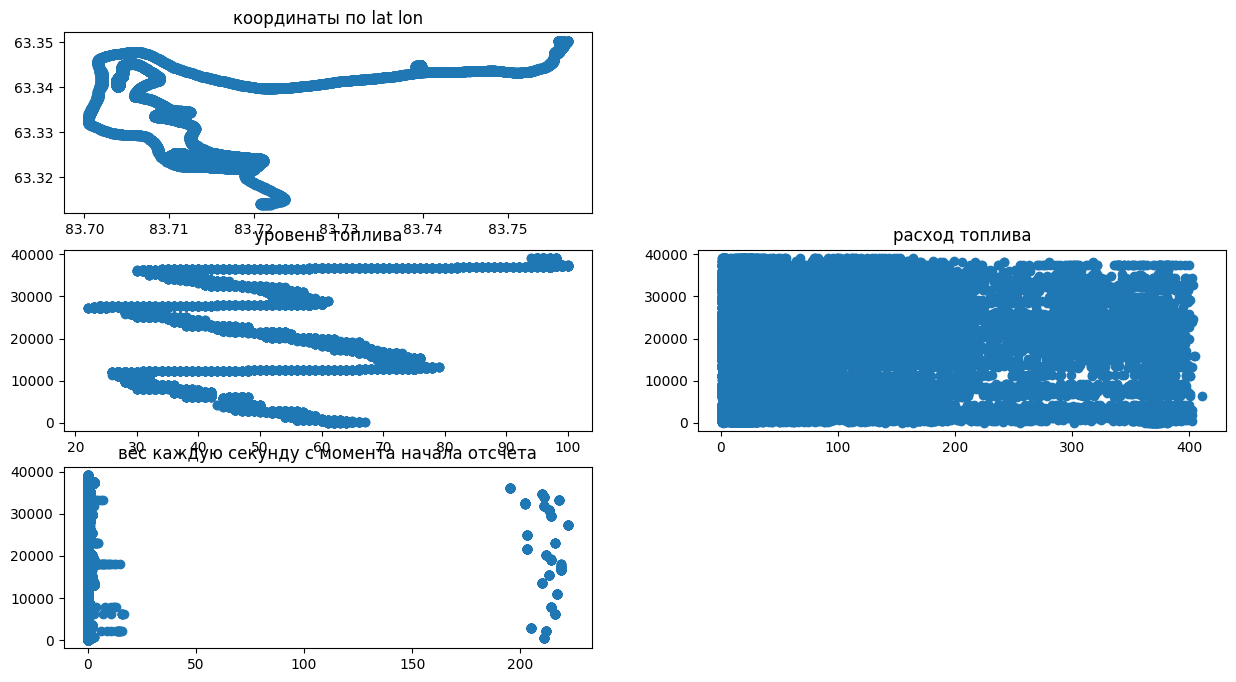

данные по самоcвалу 1123 при w_fl=1


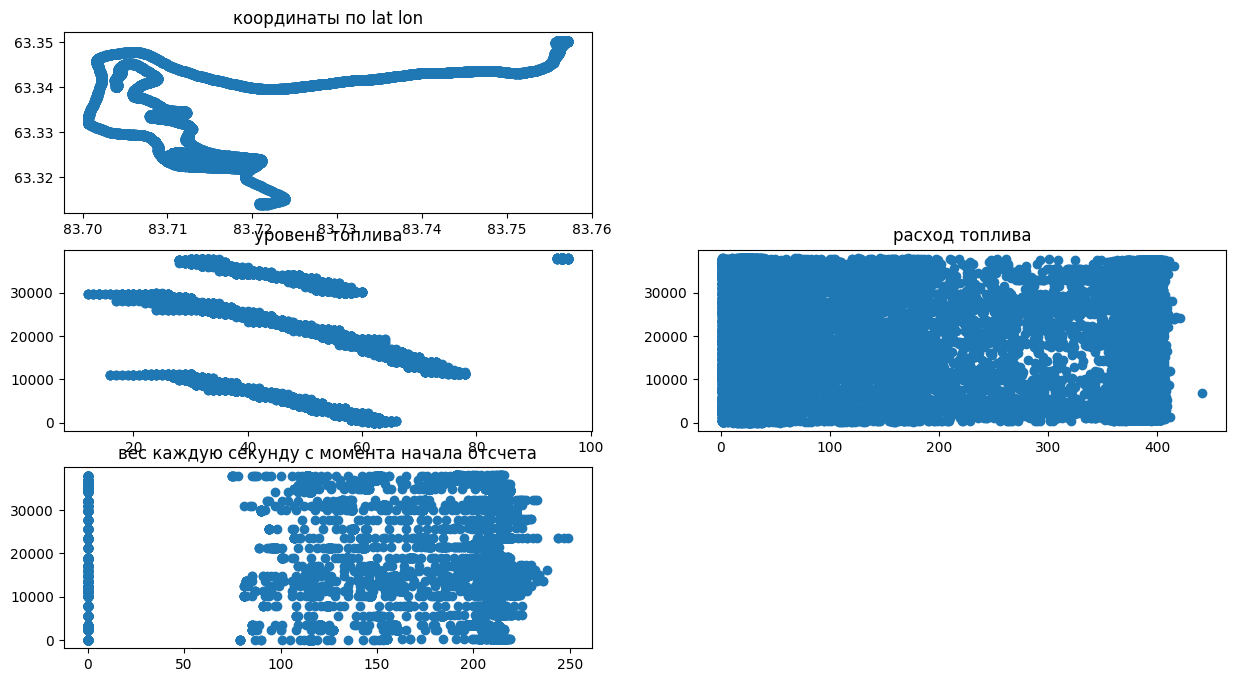

данные по самоcвалу 1124 при w_fl=0


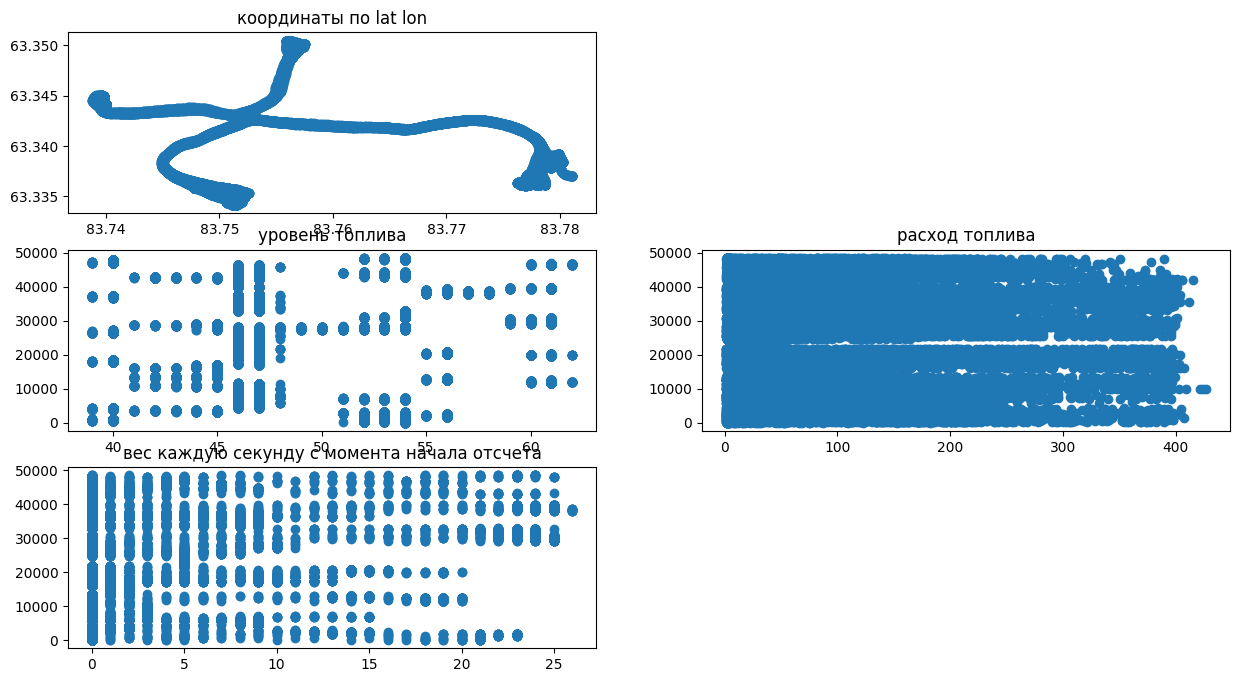

данные по самоcвалу 1124 при w_fl=1


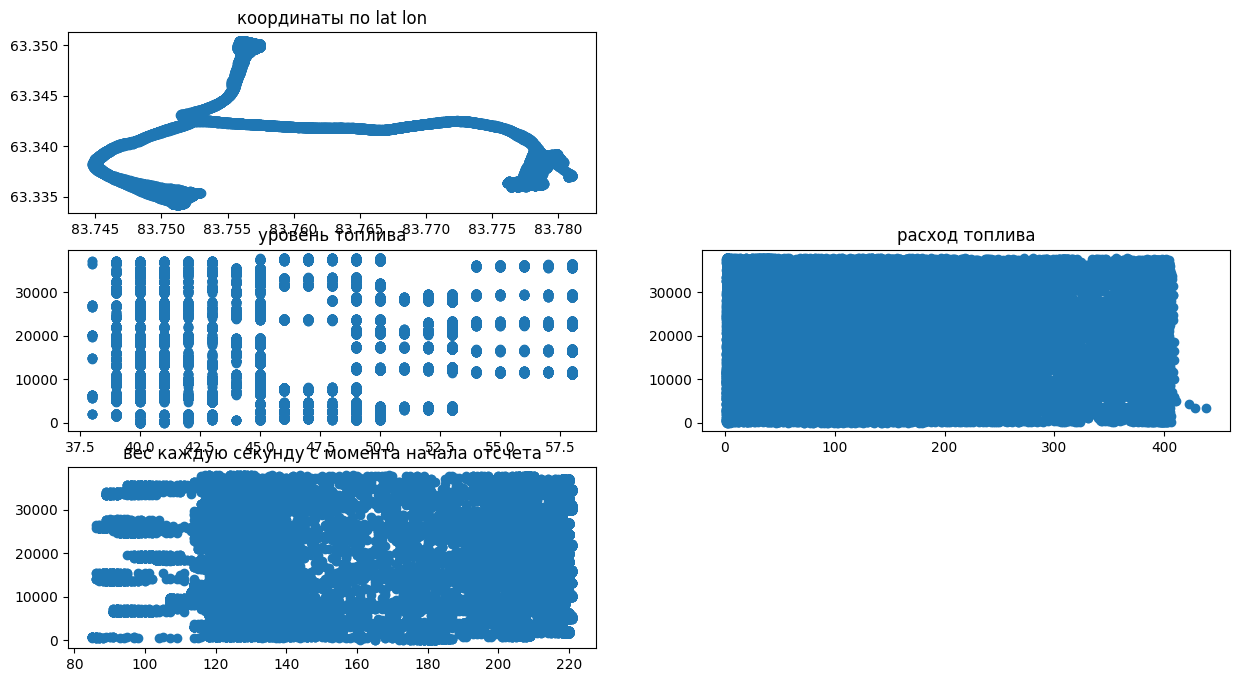

данные по самоcвалу 1125 при w_fl=0


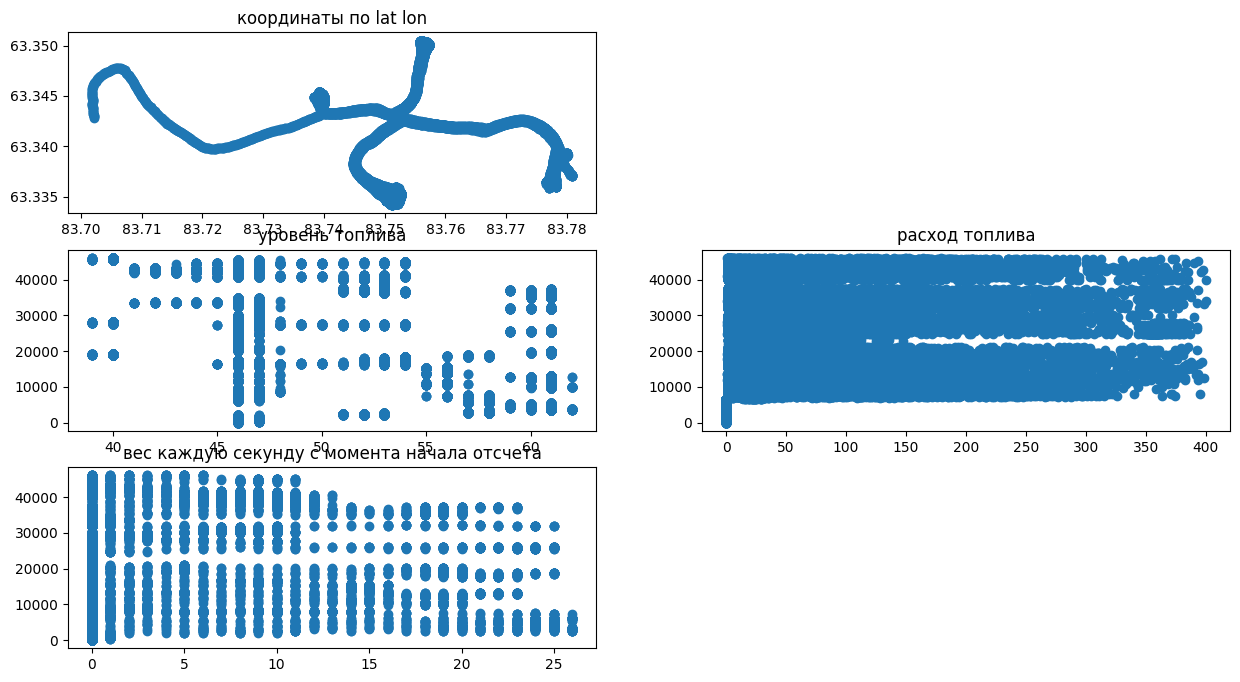

данные по самоcвалу 1125 при w_fl=1


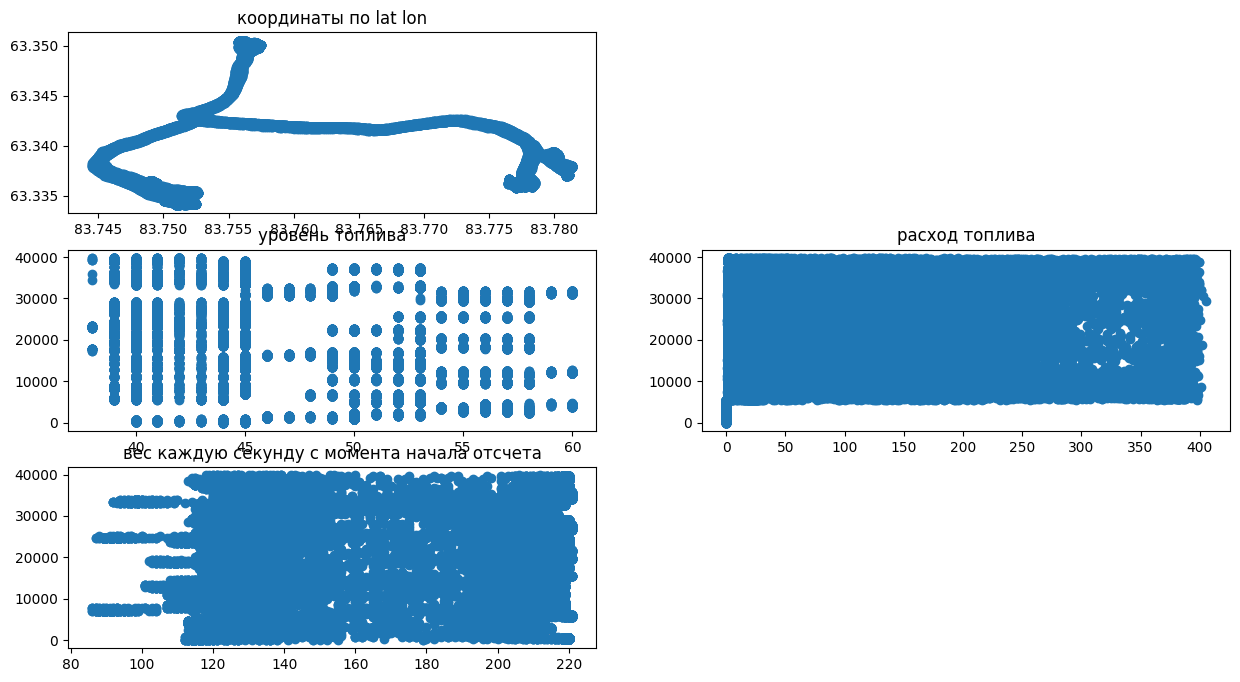

данные по самоcвалу 1126 при w_fl=0


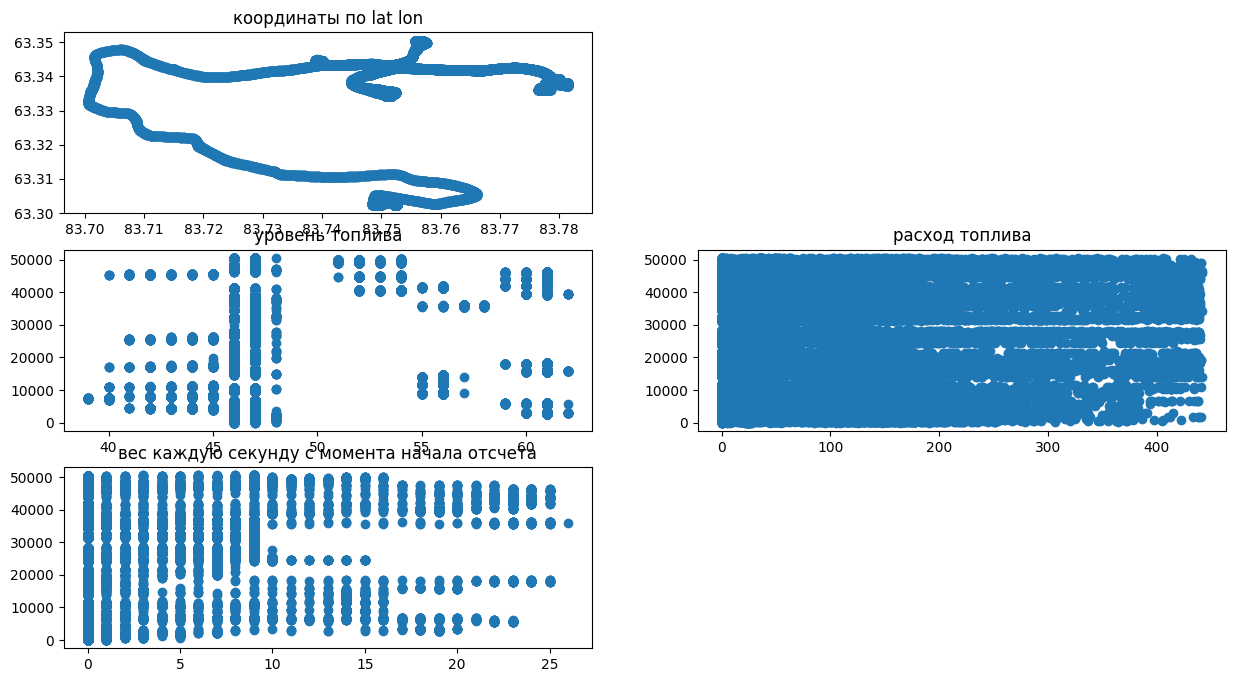

данные по самоcвалу 1126 при w_fl=1


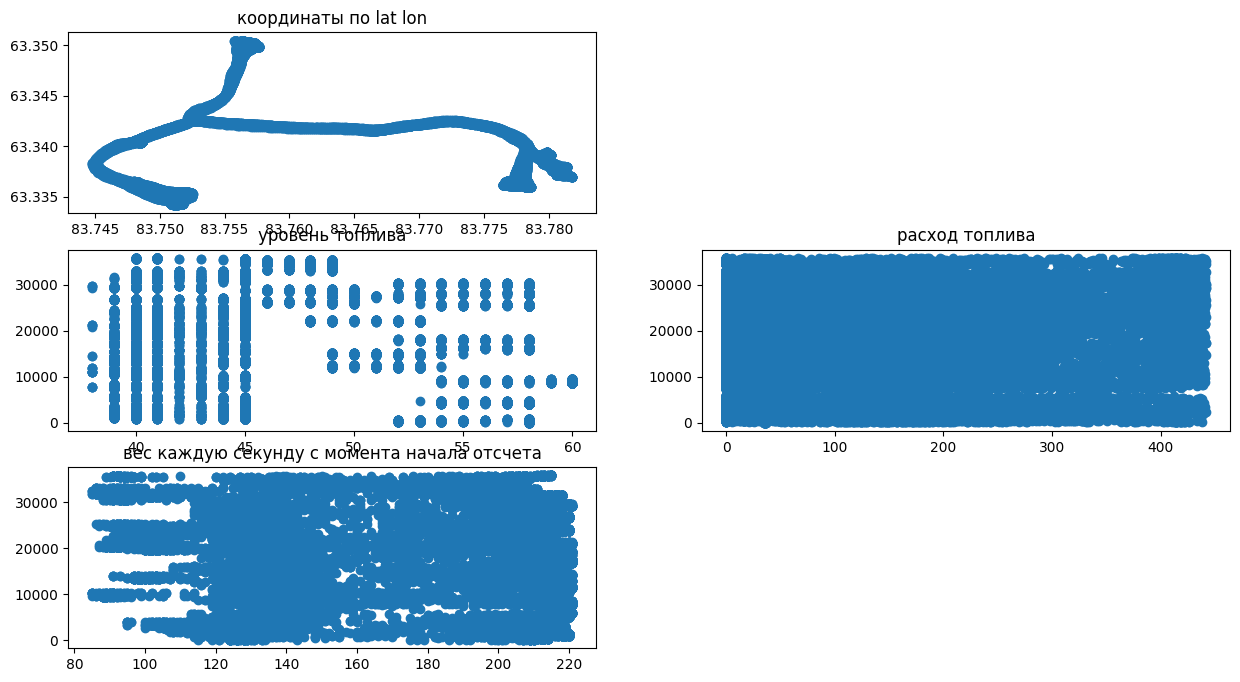

In [13]:
# строим графики для каждого самосвала
# i = id самосвала
# j = w_fl
obj_id = set(tel['objectid'])
for i in obj_id:
    for j in range(2):
        print(f'данные по самоcвалу {i} при w_fl={j}')
        tel1 = tel.loc[(tel['objectid']== i) & (tel['w_fl']==j)]
        lat = tel1['lat']
        lon = tel1['lon']
        fuel = tel1['fuel_tank_level']
        fuel_cons = tel1['fuel_cons']
        weight_min = tel1['weight_dynamic']
        plt.figure(figsize=(15,8))
        plt.title(str(i)+' при w_fl='+str(j))
        plt.subplot(3,2,1)
        plt.scatter(lon,lat)
        plt.title('координаты по lat lon')
        plt.subplot(3,2,3)
        plt.scatter(fuel,[i for i in range(len(fuel))])
        plt.title('уровень топлива')
        plt.subplot(3,2,4)
        plt.scatter(fuel_cons,[i for i in range(len(fuel_cons))])
        plt.title('расход топлива')
        plt.subplot(3,2,5)
        plt.scatter(weight_min,[i for i in range(len(weight_min))])
        plt.title('вес каждую секунду с момента начала отсчета')
        plt.show()